# Problem Statement
- The problem is to categorize the event descriptions, that may fall in to one or more categories. This type of problem can be mapped to multi-label classification, where a event can have one more categories associated with it.
- As the event are in the form of text we can leverage the power of NPL to complete this task.

# Data Description
- Dataset consists 3 parts Train, Dev and Test from Safe City
- Each parts contains four columns -
 - Description (string object): Personal story of a victim that was shared on social media with MeToo hashtag.
 - Commenting (integer): Label for the description stating whether it belongs to Commenting category or not.
 - Ogling/Facial Expressions/Staring (integer): Label for the description stating whether it belongs to any of the Ogling, Facial Expressions, Staring categories or not.
 - Touching /Groping (integer): Label for the description stating whether it belongs to any of Touching, Groping category or  not.

# Goal
- Create a text classifier that will streamline the process of categorizing Events of Harasment
- Classify Events of Harasment 3 categories using natural Language Processing and Machine Learning

# Business Constraint
- Misclassification is a big issue
- Latancy is not an issue considering end user requirement

# Evaluation Metrics
- We can use many evaluation metrics like :
    - F1 Score with Micro or Macro as average.
    - Precision or Recall
    - Hamming Loss
    - Exact Match Ratio
    - Log Loss with label powerset

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from tqdm import tqdm
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import DistilBertConfig, DistilBertTokenizer, TFDistilBertModel, pipeline
from collections import OrderedDict
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import hamming_loss
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from prettytable import PrettyTable
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings("ignore")

C:\Users\Lucifer MorningStar\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package wordnet to C:\Users\Lucifer
[nltk_data]     MorningStar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading Data

In [2]:
train = pd.read_csv('train.csv')
train.drop_duplicates(inplace = True) # Removing Duplicates
print(train.shape)
train.head(2)

(6773, 4)


,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0


In [3]:
test = pd.read_csv('test.csv')
test.drop_duplicates(inplace = True) # Removing Duplicates
print(test.shape)
test.head(2)

(1640, 4)


,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping
0,"During morning, a woman was walking by and thi...",1,1,0
1,A man tried to brush his penis off of a woman'...,0,0,1


In [4]:
dev = pd.read_csv('dev.csv')
dev.drop_duplicates(inplace = True) # Removing Duplicates
print(dev.shape)
dev.head(2)

(962, 4)


,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping
0,Buses approaching to this place is highly unsafe.,1,0,1
1,a man was commenting at me.,1,0,0


In [5]:
def splitter(df): # Simple Fuction for Spliting X and y from DataFrame
    x = df.Description
    y = df.drop('Description', axis = 1)
    return x, y

In [6]:
X_train, y_train = splitter(train)

In [7]:
X_test, y_test = splitter(test)

In [8]:
X_dev, y_dev = splitter(dev)

### EDA

In [77]:
def ploter(X, Y, name):
    fig, (ax1) = plt.subplots(1, figsize = (7, 7))
    wordcloud = WordCloud(background_color = 'white', width = 600, height = 600).generate(" ".join(X))
    ax1.imshow(wordcloud)
    ax1.axis('off')
    ax1.set_title('{} data Frequent Words'.format(name))
    plt.show(ax1)
    
    print('-'*68)     
    
    labels = ['Zero','One','Two','Three'] #REF
    plt.figure(figsize = (8,5))
    value_counts = Y.sum(axis = 1).value_counts() # Summing up to get number of labels for a given datapoint
    no_of_points_perlabel = [value_counts[i] for i in range(4)] # Getting value counts for specific label count to match with x-axis for plotting
    ax = sb.barplot(labels, no_of_points_perlabel,palette = 'magma')
    for i in range(4):
        ax.text(x = i, y = no_of_points_perlabel[i]+10, s = no_of_points_perlabel[i], ha = 'center')
    plt.title("Number of labels vs number of stories in {} data".format(name))
    plt.ylabel('Number of Stories')
    plt.xlabel('labels count')
    plt.show()
    
    print('-'*68)
    
    temp = []
    cols = Y.columns
    for col in cols:
        temp.append(Y[col][Y[col]==1].count())

    plt.figure(figsize = (8, 6))
    sb.barplot(['Commenting', 'Staring', 'Touching'], temp)
    plt.title('{} Label Count'.format(name))
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.show()
    
    print('-'*68)

    temp = []
    cols = Y.columns
    for col in cols:
        tf = TfidfVectorizer(stop_words = 'english')
        tf.fit(X[Y[col]==1])

        d = {}
        for i in (range(len(tf.idf_))):
            d[tf.idf_[i]] = tf.get_feature_names()[i]    

        rare = list(OrderedDict(sorted(d.items(), reverse = True)).values())[:10]
        freq = list(OrderedDict(sorted(d.items(), reverse = False)).values())[:10]
        df = pd.DataFrame()
        df['Frequent Words'] = freq
        df['Rare Words'] = rare
        print('|', col, '|')
        print('-'*(len(col)+4))
        print(df)

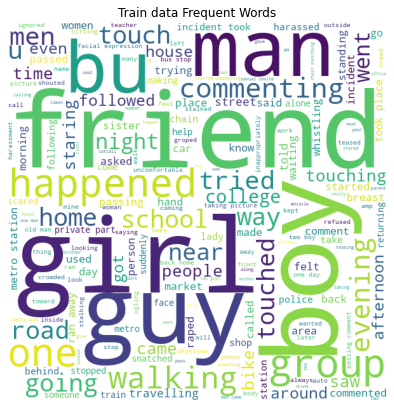

--------------------------------------------------------------------


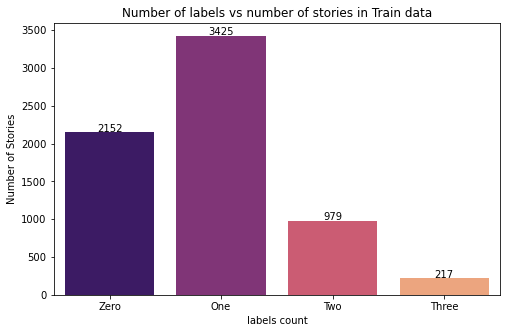

--------------------------------------------------------------------


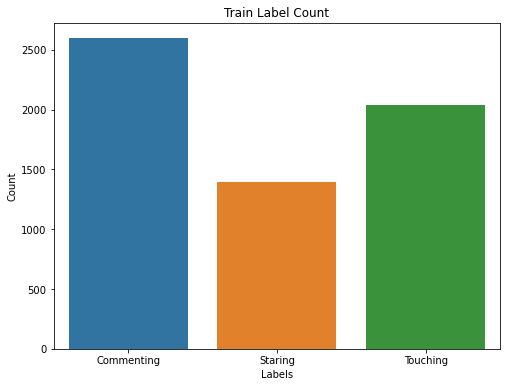

--------------------------------------------------------------------
| Commenting |
--------------
  Frequent Words Rare Words
0     commenting        zoo
1           boys     zoomed
2       comments        yrs
3        started      worst
4          group    younger
5           guys    witness
6        evening        yes
7        passing  yearstype
8            man      weird
9        walking       year
| Ogling/Facial Expressions/Staring |
-------------------------------------
  Frequent Words Rare Words
0        staring     zoomed
1            man    younger
2           boys        yrs
3     commenting    wrongly
4       comments    winking
5         friend      watch
6       happened  witnessed
7           guys      young
8            bus    working
9        started      wrong
| Touching /Groping |
---------------------
  Frequent Words Rare Words
0            man       zone
1        touched        zor
2            bus    wrongly
3       touching        yrs
4          touch     yell

In [78]:
ploter(X_train, y_train, 'Train')

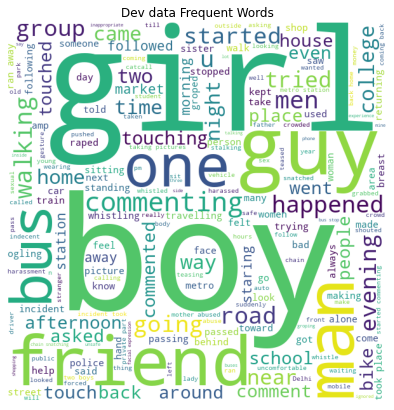

--------------------------------------------------------------------


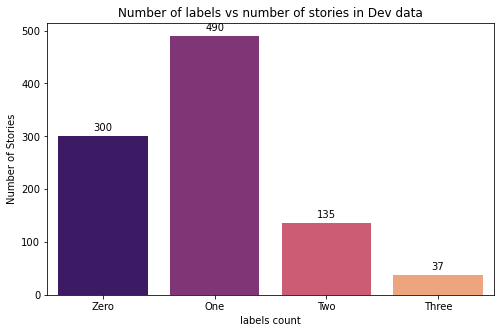

--------------------------------------------------------------------


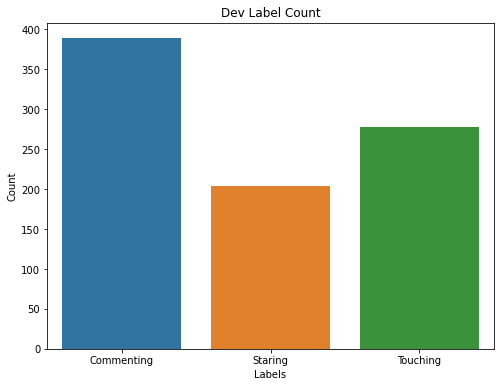

--------------------------------------------------------------------
| Commenting |
--------------
  Frequent Words     Rare Words
0     commenting          zakir
1           boys          young
2       comments          woman
3      commented         vulgar
4           guys        wearing
5          going        waiting
6        started          words
7        walking          women
8            bus       whistled
9            man  uncomfortable
| Ogling/Facial Expressions/Staring |
-------------------------------------
  Frequent Words Rare Words
0        staring     zipped
1     commenting      young
2           boys      years
3         ogling       went
4            man      women
5            men      weird
6           guys  whistling
7       happened     sexual
8          metro     street
9        started    walking
| Touching /Groping |
---------------------
  Frequent Words  Rare Words
0            man  youngsters
1       touching     yatayat
2          touch        year
3    

In [79]:
ploter(X_dev, y_dev, 'Dev')

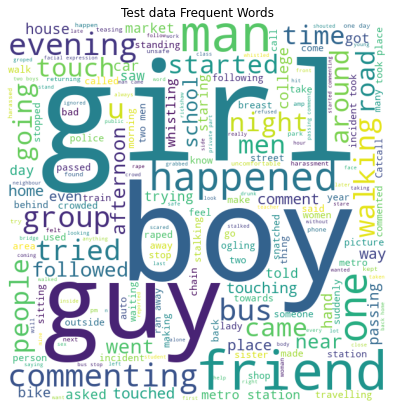

--------------------------------------------------------------------


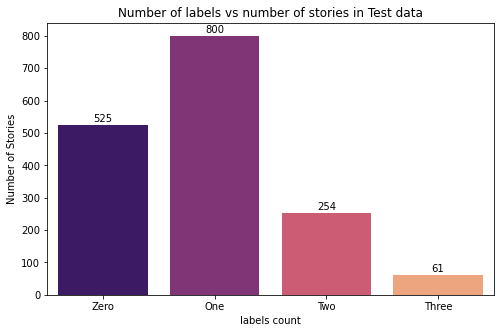

--------------------------------------------------------------------


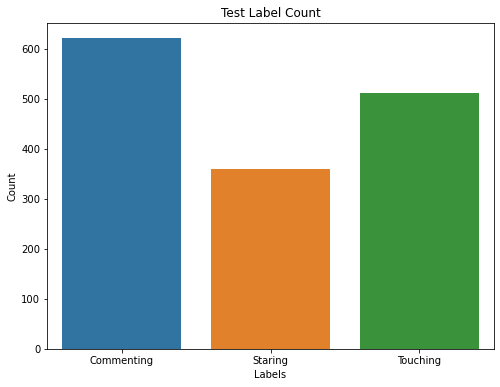

--------------------------------------------------------------------
| Commenting |
--------------
  Frequent Words      Rare Words
0     commenting  zippedunzipped
1           boys         youquot
2       comments            year
3           guys           young
4        evening            want
5        started            work
6          girls           woman
7        walking           train
8        passing            used
9       happened         waiting
| Ogling/Facial Expressions/Staring |
-------------------------------------
  Frequent Words      Rare Words
0        staring  zippedunzipped
1     commenting             yes
2        station           young
3       comments           words
4            man            work
5            men        whistles
6          metro           years
7           guys            walk
8         ogling         waiting
9          girls          trying
| Touching /Groping |
---------------------
  Frequent Words      Rare Words
0            man  zipp

In [80]:
ploter(X_test, y_test, 'Test')

# Text Cleaning/Preprocessing

In [9]:
def preprocess_text(text_data):
    import numpy as np
    import re
    def decontracted(phrase): # Function to Decontract words like 'won't' to 'will not' and so on
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"didn't", "did not", phrase)
        phrase = re.sub(r"havn't", "have not", phrase)
        phrase = re.sub(r"hasn't", "has not", phrase)
        phrase = re.sub(r"can't", "can not", phrase)
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        if bool(re.search(r'\d', phrase)):
            phrase = re.sub('[0-9]{5,}', '#####', phrase)
            phrase = re.sub('[0-9]{4}', '####', phrase)
            phrase = re.sub('[0-9]{3}', '###', phrase)
            phrase = re.sub('[0-9]{2}', '##', phrase)
        return phrase

    preprocessed_text = []
    for sentance in tqdm(text_data): # Function to lemmtize, Stem words and further cleaning of text
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        preprocessed_text.append(sent.lower().strip())
    return np.array(preprocessed_text)

In [10]:
X_train_pre = preprocess_text(X_train)

100%|███████████████████████████████████████████████████████████████████████████| 6773/6773 [00:00<00:00, 29834.53it/s]


In [11]:
X_test_pre = preprocess_text(X_test)

100%|███████████████████████████████████████████████████████████████████████████| 1640/1640 [00:00<00:00, 29285.59it/s]


In [12]:
X_dev_pre = preprocess_text(X_dev)

100%|█████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 34358.76it/s]


In [241]:
w2v_model = KeyedVectors.load_word2vec_format(r'D:Downloads/GoogleNews-vectors-negative300.bin.gz', binary = True)
def w2v(X):
    words = list(w2v_model.key_to_index.keys())
    x = []
    for sentence in tqdm(X): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        for word in sentence.split(): # for each word in a review/sentence
            if word in words:
                vector += w2v_model[word]
        x.append(vector)
    x = np.array(x)
    return x

In [242]:
from gensim.models import FastText
def load_fasttext():
    fast_text_model = {}
    f = open(r'D:Downloads/wiki-news-300d-1M.vec',encoding='utf-8')
    for line in tqdm(f):
        values = line.strip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        fast_text_model[word] = coefs
    f.close()
    return fast_text_model
fast_text = load_fasttext()

999995it [02:06, 7875.84it/s] 


In [243]:
def fast_text_embed(X):
    x = []
    for sentence in tqdm(X): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        for word in sentence.split(): # for each word in a review/sentence
            if word in fast_text.keys():
                vector += fast_text[word]
        x.append(vector)
    x = np.array(x)
    return x

In [244]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # Loading Tokenizer
config = DistilBertConfig.from_pretrained('distilbert-base-uncased', output_hidden_states = True) # Loading COnfig File
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config) # Loading Model

nlp = pipeline('feature-extraction', model = model, tokenizer = tokenizer, framework = "tf") # Defining Pipling as Feature-Extractor
def convertion(string):
    inputs = tokenizer(string, return_tensors = "tf")
    outputs = model(inputs)
    outputs = np.concatenate((outputs[1][6][0,0,:],outputs[1][5][0,0,:],outputs[1][4][0,0,:],outputs[1][3][0,0,:]), axis=0) # Concatinating Only 3,4,5,6 layer of BERT
    return np.array(outputs)

def convertor(X):
    sent =[]
    vec=[]
    for i in tqdm(X):
        text = i[:512]
        vec.append(convertion(text))
    return vec

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [13]:
def auto_models(train_data, dev_data, test_data, vectorizor_mode, model_mode):
    '''Available Vectorizor Modes: {None, BOW, TFIDF, W2V, BERT, Fast, DL}
       Avialable Model Modes: {None, KNN, LGR, RF}'''
    train_x, train_y = train
    dev_x, dev_y = dev
    test_x, test_y = test
    scores = {}
    tab = PrettyTable()
    if vectorizor_mode != 'None':
        print('|', vectorizor_mode, '|')
        print('-'*(len(vectorizor_mode)+4))
        if vectorizor_mode.lower() == 'bow':
            bow = CountVectorizer(ngram_range = (1, 4))
            train_x = bow.fit_transform(train_x)
            pickle.dump(bow, open('bow.pkl', 'wb'))
            dev_x = bow.transform(dev_x)
            test_x = bow.transform(test_x)

        if vectorizor_mode.lower() == 'tfidf':
            tfidf = TfidfVectorizer(ngram_range = (1, 4))
            train_x = tfidf.fit_transform(train_x)
            pickle.dump(tfidf, open('tfidf.pkl', 'wb'))
            dev_x = tfidf.transform(dev_x)
            test_x = tfidf.transform(test_x)

        if vectorizor_mode.lower() == 'w2v':
            train_x = w2v(train_x)
            dev_x = w2v(dev_x)
            test_x = w2v(test_x)

        if vectorizor_mode.lower() == 'bert':
            train_x = convertor(train_x) # Getting BERT Emedding/Features
            train_x = np.array(train_x) # Type Casting as Array

            dev_x = convertor(dev_x) # Getting BERT Emedding/Features
            dev_x = np.array(dev_x) # Type Casting as Array

            test_x = convertor(test_x) # Getting BERT Emedding/Features
            test_x = np.array(test_x) # Type Casting as Array

        if vectorizor_mode.lower() == 'fast':
            train_x = fast_text_embed(train_x)
            dev_x = fast_text_embed(dev_x)
            test_x = fast_text_embed(test_x)
            
        if vectorizor_mode.lower() == 'dl':
            c = 0
            for i in train_x:
                c += len(i)

            tok = Tokenizer(num_words = c, oov_token = 'oov', char_level = True)

            tok.fit_on_texts(train_x)

            vocab_size = len(tok.word_index) + 1

            train_seq = tok.texts_to_sequences(train_x)
            dev_seq = tok.texts_to_sequences(dev_x)
            test_seq = tok.texts_to_sequences(test_x)

            max_len = max(pd.Series(train_x).str.split().apply(len).value_counts())

            train_x = pad_sequences(train_seq, maxlen = max_len, padding = 'post', truncating = 'post')
            dev_x = pad_sequences(dev_seq, maxlen = max_len, padding = 'post', truncating = 'post')
            test_x = pad_sequences(test_seq, maxlen = max_len, padding = 'post', truncating = 'post')
            
            train_x = feat_ext.predict(train_x)
            dev_x = feat_ext.predict(dev_x)
            test_x = feat_ext.predict(test_x)
        
    if model_mode.lower() == 'none':
        return train_x, dev_x, test_x
        
    if model_mode.lower() != 'none':
        if model_mode.lower() == 'knn':
            tab.field_names = ['Compliment Hamming Loss', 'K']
            for k in tqdm(range(1, 30, 2)):
                model = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
                model.fit(train_x, train_y)
                score = 1-hamming_loss(dev_y, model.predict(dev_x))
                scores[score] = k
                tab.add_row([score, k])
                if len(scores) != 12:
                    tab.add_row(['-'*18, '-'*5])
            best_value = list(OrderedDict(sorted(scores.items(), reverse = True)).values())[0]
            model = KNeighborsClassifier(n_neighbors = best_value, n_jobs = -1)
            model.fit(train_x, train_y)
            pickle.dump(model, open('knn.sav', 'wb'))
            name = 'K'

        if model_mode.lower() == 'lgr':
            tab.field_names = ['Compliment Hamming Loss', 'C']
            values = np.random.uniform(0, 10, 10)
            for c in tqdm(values):
                model = MultiOutputClassifier(LogisticRegression(C = c, class_weight = 'imbalanced'))
                model.fit(train_x, train_y)
                score = 1-hamming_loss(dev_y, model.predict(dev_x))
                scores[score] = c
                tab.add_row([score, c])
                if len(scores) != 12:
                    tab.add_row(['-'*18, '-'*5])
            best_value = list(OrderedDict(sorted(scores.items(), reverse = True)).values())[0]
            model = MultiOutputClassifier(LogisticRegression(C = best_value, class_weight = 'imbalanced'))
            model.fit(train_x, train_y)
            pickle.dump(model, open('lgr.sav', 'wb'))
            name = 'C'

        if model_mode.lower() == 'rf':
            tab.field_names = ['Compliment Hamming Loss', 'n_estimators']
            values = list(range(100, 601, 100))
            for n in tqdm(values):
                model = RandomForestClassifier(n_estimators = n, n_jobs = -1, class_weight = 'balanced')
                model.fit(train_x, train_y)
                score = 1-hamming_loss(dev_y, model.predict(dev_x))
                scores[score] = n
                tab.add_row([score, n])
                if len(scores) != 12:
                    tab.add_row(['-'*18, '-'*5])
            best_value = list(OrderedDict(sorted(scores.items(), reverse = True)).values())[0]
            model = RandomForestClassifier(n_estimators = best_value, n_jobs = -1, class_weight = 'balanced')
            model.fit(train_x, train_y)
            pickle.dump(model, open('rf.sav', 'wb'))
            name = 'n_estimators'
        score = 1-hamming_loss(test_y, model.predict(test_x))
        print(tab)
        print('Best Score on {} with {} on Test data: {}'.format(model_mode, best_value, score))
        return score

# BOW
#### KNN

In [22]:
knn_bow_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'BOW', 'KNN')

| BOW |
-------


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.49it/s]


+-------------------------+-------+
| Compliment Hamming Loss |   K   |
+-------------------------+-------+
|    0.6628551628551629   |   1   |
|    ------------------   | ----- |
|    0.6978516978516979   |   3   |
|    ------------------   | ----- |
|    0.7151767151767152   |   5   |
|    ------------------   | ----- |
|    0.7214137214137214   |   7   |
|    ------------------   | ----- |
|    0.717948717948718    |   9   |
|    ------------------   | ----- |
|    0.7210672210672211   |   11  |
|    ------------------   | ----- |
|    0.7273042273042273   |   13  |
|    ------------------   | ----- |
|    0.7255717255717256   |   15  |
|    ------------------   | ----- |
|    0.7234927234927235   |   17  |
|    ------------------   | ----- |
|    0.7231462231462231   |   19  |
|    ------------------   | ----- |
|    0.7231462231462231   |   21  |
|    ------------------   | ----- |
|    0.7255717255717256   |   23  |
|    ------------------   | ----- |
|    0.7311157311157311   | 

#### Logistic Regression

In [248]:
lgr_bow_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'BOW', 'LGR')

| BOW |
-------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.77s/it]


+-------------------------+--------------------+
| Compliment Hamming Loss |         C          |
+-------------------------+--------------------+
|    0.8225918225918226   | 6.350664570437665  |
|    ------------------   |       -----        |
|    0.8229383229383229   | 6.463854020426137  |
|    ------------------   |       -----        |
|    0.8239778239778239   | 3.9373642622835625 |
|    ------------------   |       -----        |
|    0.8243243243243243   | 1.658123911837518  |
|    ------------------   |       -----        |
|    0.8232848232848233   | 6.717666606613929  |
|    ------------------   |       -----        |
|    0.8218988218988219   | 4.988681108889493  |
|    ------------------   |       -----        |
|    0.8236313236313236   | 3.9196684058668163 |
|    ------------------   |       -----        |
|    0.8236313236313236   | 1.3281862369887554 |
|    ------------------   |       -----        |
|    0.8246708246708246   | 3.1821164501131207 |
|    ---------------

#### Random Forest

In [249]:
rf_bow_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'BOW', 'RF')

| BOW |
-------


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [21:26<00:00, 214.41s/it]


+-------------------------+--------------+
| Compliment Hamming Loss | n_estimators |
+-------------------------+--------------+
|    0.795911295911296    |     100      |
|    ------------------   |    -----     |
|    0.7962577962577962   |     200      |
|    ------------------   |    -----     |
|    0.7976437976437977   |     300      |
|    ------------------   |    -----     |
|    0.7983367983367984   |     400      |
|    ------------------   |    -----     |
|    0.7962577962577962   |     500      |
|    ------------------   |    -----     |
|    0.7941787941787941   |     600      |
|    ------------------   |    -----     |
+-------------------------+--------------+
Best Score on RF with 400 on Test data: 0.7995934959349593


# TFIDF

#### KNN

In [250]:
knn_TFIDF_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'TFIDF', 'KNN')

| TFIDF |
---------


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.97it/s]


+-------------------------+-------+
| Compliment Hamming Loss |   K   |
+-------------------------+-------+
|    0.5665280665280665   |   1   |
|    ------------------   | ----- |
|    0.7176022176022177   |   3   |
|    ------------------   | ----- |
|    0.7467082467082466   |   5   |
|    ------------------   | ----- |
|    0.7702702702702703   |   7   |
|    ------------------   | ----- |
|    0.7775467775467775   |   9   |
|    ------------------   | ----- |
|    0.7785862785862786   |   11  |
|    ------------------   | ----- |
|    0.7837837837837838   |   13  |
|    ------------------   | ----- |
|    0.7862092862092862   |   15  |
|    ------------------   | ----- |
|    0.7851697851697852   |   17  |
|    ------------------   | ----- |
|    0.7920997920997921   |   19  |
|    ------------------   | ----- |
|    0.7903672903672904   |   21  |
|    ------------------   | ----- |
|    0.7907137907137907   |   23  |
|    0.7934857934857935   |   25  |
|    ------------------   | 

#### Logistic Regression

In [251]:
lgr_TFIDF_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'TFIDF', 'LGR')

| TFIDF |
---------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.05s/it]


+-------------------------+--------------------+
| Compliment Hamming Loss |         C          |
+-------------------------+--------------------+
|    0.8232848232848233   | 3.4737372703164526 |
|    ------------------   |       -----        |
|    0.8118503118503119   | 0.8227587967112937 |
|    ------------------   |       -----        |
|    0.8225918225918226   | 1.609393450917358  |
|    ------------------   |       -----        |
|    0.8239778239778239   | 1.8293391143261062 |
|    ------------------   |       -----        |
|    0.8239778239778239   | 8.711640532166827  |
|    ------------------   |       -----        |
|    0.8239778239778239   | 5.432843711296447  |
|    ------------------   |       -----        |
|    0.8236313236313236   | 3.593051002639193  |
|    ------------------   |       -----        |
|    0.8243243243243243   | 9.440876921358818  |
|    ------------------   |       -----        |
|    0.8222453222453222   | 3.3420621880806545 |
|    ---------------

#### Random Forest

In [252]:
rf_TFIDF_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'TFIDF', 'RF')

| TFIDF |
---------


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [19:52<00:00, 198.75s/it]


+-------------------------+--------------+
| Compliment Hamming Loss | n_estimators |
+-------------------------+--------------+
|    0.7896742896742897   |     100      |
|    ------------------   |    -----     |
|    0.795911295911296    |     200      |
|    ------------------   |    -----     |
|    0.7941787941787941   |     300      |
|    ------------------   |    -----     |
|    0.7962577962577962   |     400      |
|    ------------------   |    -----     |
|    0.7962577962577962   |     500      |
|    ------------------   |    -----     |
|    0.7945252945252945   |     600      |
|    ------------------   |    -----     |
+-------------------------+--------------+
Best Score on RF with 500 on Test data: 0.7941056910569105


# W2V

#### KNN

In [253]:
knn_w2v_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'W2V', 'KNN')

  0%|                                                                                         | 0/6773 [00:00<?, ?it/s]

| W2V |
-------


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.89it/s]


+-------------------------+-------+
| Compliment Hamming Loss |   K   |
+-------------------------+-------+
|    0.7401247401247402   |   1   |
|    ------------------   | ----- |
|    0.7681912681912682   |   3   |
|    ------------------   | ----- |
|    0.7792792792792793   |   5   |
|    ------------------   | ----- |
|    0.7841302841302842   |   7   |
|    ------------------   | ----- |
|    0.7934857934857935   |   9   |
|    ------------------   | ----- |
|    0.7914067914067914   |   11  |
|    ------------------   | ----- |
|    0.7920997920997921   |   13  |
|    ------------------   | ----- |
|    0.7945252945252945   |   15  |
|    ------------------   | ----- |
|    0.7865557865557866   |   17  |
|    ------------------   | ----- |
|    0.7855162855162855   |   19  |
|    ------------------   | ----- |
|    0.7848232848232848   |   21  |
|    ------------------   | ----- |
|    0.7862092862092862   |   23  |
|    0.7851697851697852   |   25  |
|    ------------------   | 

#### Logistic Regression

In [254]:
lgr_w2v_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'W2V', 'LGR')

  0%|                                                                                 | 1/6773 [00:00<34:59,  3.23it/s]

| W2V |
-------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


+-------------------------+---------------------+
| Compliment Hamming Loss |          C          |
+-------------------------+---------------------+
|    0.8270963270963271   |  0.578602154816088  |
|    ------------------   |        -----        |
|    0.8274428274428274   |   8.36682557115468  |
|    ------------------   |        -----        |
|    0.8264033264033264   |  6.582302379396695  |
|    ------------------   |        -----        |
|    0.8274428274428274   |  3.941190860199917  |
|    ------------------   |        -----        |
|    0.8281358281358282   |  1.5833323541674182 |
|    ------------------   |        -----        |
|    0.8284823284823285   | 0.13648650611377433 |
|    ------------------   |        -----        |
|    0.8270963270963271   |  2.5227072775110004 |
|    ------------------   |        -----        |
|    0.8260568260568261   |  3.346095339563766  |
|    ------------------   |        -----        |
|    0.8270963270963271   |  4.987657226050989  |


#### Random Forest

In [255]:
rf_w2v_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'W2V', 'RF')

  0%|                                                                                 | 1/6773 [00:00<31:36,  3.57it/s]

| W2V |
-------


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:43<00:00,  7.29s/it]


+-------------------------+--------------+
| Compliment Hamming Loss | n_estimators |
+-------------------------+--------------+
|    0.7688842688842689   |     100      |
|    ------------------   |    -----     |
|    0.7692307692307692   |     200      |
|    ------------------   |    -----     |
|    0.7754677754677755   |     300      |
|    ------------------   |    -----     |
|    0.772002772002772    |     400      |
|    ------------------   |    -----     |
|    0.770963270963271    |     500      |
|    ------------------   |    -----     |
|    0.7713097713097713   |     600      |
|    ------------------   |    -----     |
+-------------------------+--------------+
Best Score on RF with 300 on Test data: 0.7731707317073171


# Fast Text
#### KNN

In [264]:
knn_fast_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'Fast', 'KNN')

 11%|████████▌                                                                    | 753/6773 [00:00<00:00, 7529.61it/s]

| Fast |
--------


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


+-------------------------+-------+
| Compliment Hamming Loss |   K   |
+-------------------------+-------+
|    0.7182952182952183   |   1   |
|    ------------------   | ----- |
|    0.7505197505197505   |   3   |
|    ------------------   | ----- |
|    0.7650727650727651   |   5   |
|    ------------------   | ----- |
|    0.7636867636867637   |   7   |
|    ------------------   | ----- |
|    0.7650727650727651   |   9   |
|    ------------------   | ----- |
|    0.7650727650727651   |   11  |
|    ------------------   | ----- |
|    0.7654192654192654   |   13  |
|    ------------------   | ----- |
|    0.7702702702702703   |   15  |
|    ------------------   | ----- |
|    0.7664587664587664   |   17  |
|    ------------------   | ----- |
|    0.7654192654192654   |   19  |
|    ------------------   | ----- |
|    0.7664587664587664   |   21  |
|    ------------------   | ----- |
|    0.7664587664587664   |   23  |
|    ------------------   | ----- |
|    0.7657657657657657   | 

#### Logistic Regression

In [265]:
lgr_fast_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'Fast', 'LGR')

 13%|█████████▊                                                                   | 860/6773 [00:00<00:00, 8599.25it/s]

| Fast |
--------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]


+-------------------------+--------------------+
| Compliment Hamming Loss |         C          |
+-------------------------+--------------------+
|    0.8215523215523215   | 3.1177089980667114 |
|    ------------------   |       -----        |
|    0.8222453222453222   | 1.3905021258706196 |
|    ------------------   |       -----        |
|    0.8191268191268191   | 8.381615037468581  |
|    ------------------   |       -----        |
|    0.8218988218988219   | 2.6512586818679154 |
|    ------------------   |       -----        |
|    0.8225918225918226   | 6.207747964356914  |
|    ------------------   |       -----        |
|    0.8218988218988219   | 2.0903937355767113 |
|    ------------------   |       -----        |
|    0.8212058212058212   | 7.814063074577366  |
|    ------------------   |       -----        |
|    0.8222453222453222   | 0.8866231737936081 |
|    ------------------   |       -----        |
|    0.8208593208593209   | 1.235843774167672  |
|    ---------------

#### Random Forest

In [266]:
rf_fast_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'Fast', 'RF')

 26%|███████████████████▋                                                        | 1750/6773 [00:00<00:00, 8727.65it/s]

| Fast |
--------


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:44<00:00,  7.40s/it]


+-------------------------+--------------+
| Compliment Hamming Loss | n_estimators |
+-------------------------+--------------+
|    0.7647262647262647   |     100      |
|    ------------------   |    -----     |
|    0.7692307692307692   |     200      |
|    ------------------   |    -----     |
|    0.7668052668052668   |     300      |
|    ------------------   |    -----     |
|    0.7643797643797644   |     400      |
|    ------------------   |    -----     |
|    0.7647262647262647   |     500      |
|    ------------------   |    -----     |
|    0.7664587664587664   |     600      |
|    ------------------   |    -----     |
+-------------------------+--------------+
Best Score on RF with 200 on Test data: 0.7693089430894309


# BERT
#### KNN

In [256]:
knn_bert_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'BERT', 'KNN')

  0%|                                                                                 | 2/6773 [00:00<06:56, 16.26it/s]

| BERT |
--------


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.26s/it]


+-------------------------+-------+
| Compliment Hamming Loss |   K   |
+-------------------------+-------+
|    0.7033957033957035   |   1   |
|    ------------------   | ----- |
|    0.727997227997228    |   3   |
|    ------------------   | ----- |
|    0.7304227304227304   |   5   |
|    ------------------   | ----- |
|    0.7418572418572418   |   7   |
|    ------------------   | ----- |
|    0.7467082467082466   |   9   |
|    ------------------   | ----- |
|    0.7477477477477478   |   11  |
|    ------------------   | ----- |
|    0.7522522522522522   |   13  |
|    ------------------   | ----- |
|    0.753984753984754    |   15  |
|    ------------------   | ----- |
|    0.7560637560637561   |   17  |
|    ------------------   | ----- |
|    0.7560637560637561   |   19  |
|    ------------------   | ----- |
|    0.7557172557172557   |   21  |
|    ------------------   | ----- |
|    0.7543312543312544   |   23  |
|    ------------------   | ----- |
|    0.753984753984754    | 

#### Logistic Regression

In [257]:
lgr_bert_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'BERT', 'LGR')

  0%|                                                                                 | 2/6773 [00:00<08:27, 13.33it/s]

| BERT |
--------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.39s/it]


+-------------------------+--------------------+
| Compliment Hamming Loss |         C          |
+-------------------------+--------------------+
|    0.8073458073458073   | 3.3737695976404156 |
|    ------------------   |       -----        |
|    0.8087318087318087   | 6.718126644130608  |
|    ------------------   |       -----        |
|    0.8076923076923077   | 3.885218743423856  |
|    ------------------   |       -----        |
|    0.8090783090783091   | 2.435540650968513  |
|    ------------------   |       -----        |
|    0.8083853083853084   | 7.926926712994846  |
|    ------------------   |       -----        |
|    0.8087318087318087   | 3.4910146295321685 |
|    ------------------   |       -----        |
|    0.8083853083853084   | 4.548724989611608  |
|    ------------------   |       -----        |
|    0.8146223146223146   | 9.577174082336615  |
|    ------------------   |       -----        |
|    0.8076923076923077   | 2.885745278293844  |
|    ---------------

#### Random Forest

In [258]:
rf_bert_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'BERT', 'RF')

  0%|                                                                                 | 2/6773 [00:00<08:10, 13.79it/s]

| BERT |
--------


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:26<00:00, 24.35s/it]


+-------------------------+--------------+
| Compliment Hamming Loss | n_estimators |
+-------------------------+--------------+
|    0.7532917532917534   |     100      |
|    ------------------   |    -----     |
|    0.7484407484407485   |     200      |
|    ------------------   |    -----     |
|    0.7463617463617463   |     300      |
|    ------------------   |    -----     |
|    0.7536382536382537   |     400      |
|    ------------------   |    -----     |
|    0.7525987525987525   |     500      |
|    ------------------   |    -----     |
|    0.7515592515592515   |     600      |
|    ------------------   |    -----     |
+-------------------------+--------------+
Best Score on RF with 400 on Test data: 0.7532520325203252


### Feature Extraction

In [223]:
inp = Input(shape=(253))

# Encoder level 1
e = Dense(512)(inp)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# Encoder level 2
e = Dense(253)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# Bottleneck
bottleneck = Dense(253)(e)

d = Dense(253)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# Decoder level 2
d = Dense(512)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
output = Dense(253, activation = None)(d)
output = LeakyReLU()(output)

# define autoEncoder Model

feat_ext = Model(inputs=inp, outputs=output)
feat_ext.compile('adam', 'mse')
feat_ext.summary()

check = ModelCheckpoint('feat_ext.h5', verbose = 1, save_best_only = True)
feat_ext.fit(X_train_pad, X_train_pad, epochs = 200, batch_size = 128, validation_data = (X_dev_pad, X_dev_pad),
          callbacks = check)

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 253)]             0         
_________________________________________________________________
dense_124 (Dense)            (None, 512)               130048    
_________________________________________________________________
batch_normalization_62 (Batc (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_74 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 253)               129789    
_________________________________________________________________
batch_normalization_63 (Batc (None, 253)               1012      
_________________________________________________________________
leaky_re_lu_75 (LeakyReLU)   (None, 253)               0  

Epoch 25/200
48/53 [==========================>...] - ETA: 0s - loss: 2.8864
Epoch 00025: val_loss improved from 3.76004 to 3.65822, saving model to feat_ext.h5
53/53 [==============================] - 0s 8ms/step - loss: 2.8805 - val_loss: 3.6582
Epoch 26/200
46/53 [=========================>....] - ETA: 0s - loss: 2.8060
Epoch 00026: val_loss did not improve from 3.65822
53/53 [==============================] - 0s 7ms/step - loss: 2.8137 - val_loss: 3.6640
Epoch 27/200
47/53 [=========================>....] - ETA: 0s - loss: 2.7430
Epoch 00027: val_loss did not improve from 3.65822
53/53 [==============================] - 0s 7ms/step - loss: 2.7598 - val_loss: 3.8535
Epoch 28/200
44/53 [=======================>......] - ETA: 0s - loss: 2.7368
Epoch 00028: val_loss improved from 3.65822 to 3.60041, saving model to feat_ext.h5
53/53 [==============================] - 0s 9ms/step - loss: 2.7440 - val_loss: 3.6004
Epoch 29/200
46/53 [=========================>....] - ETA: 0s - loss: 2.66

47/53 [=========================>....] - ETA: 0s - loss: 1.6301
Epoch 00060: val_loss did not improve from 2.56909
53/53 [==============================] - 0s 7ms/step - loss: 1.6340 - val_loss: 2.6630
Epoch 61/200
48/53 [==========================>...] - ETA: 0s - loss: 1.6466
Epoch 00061: val_loss improved from 2.56909 to 2.52784, saving model to feat_ext.h5
53/53 [==============================] - 0s 8ms/step - loss: 1.6450 - val_loss: 2.5278
Epoch 62/200
48/53 [==========================>...] - ETA: 0s - loss: 1.6013
Epoch 00062: val_loss improved from 2.52784 to 2.52434, saving model to feat_ext.h5
53/53 [==============================] - 0s 8ms/step - loss: 1.6020 - val_loss: 2.5243
Epoch 63/200
47/53 [=========================>....] - ETA: 0s - loss: 1.5702
Epoch 00063: val_loss did not improve from 2.52434
53/53 [==============================] - 0s 6ms/step - loss: 1.5808 - val_loss: 2.5304
Epoch 64/200
48/53 [==========================>...] - ETA: 0s - loss: 1.5825
Epoch 0006

53/53 [==============================] - 0s 8ms/step - loss: 1.2001 - val_loss: 2.0875
Epoch 97/200
49/53 [==========================>...] - ETA: 0s - loss: 1.1504
Epoch 00097: val_loss did not improve from 2.08746
53/53 [==============================] - 0s 6ms/step - loss: 1.1507 - val_loss: 2.0925
Epoch 98/200
46/53 [=========================>....] - ETA: 0s - loss: 1.1475
Epoch 00098: val_loss improved from 2.08746 to 2.04105, saving model to feat_ext.h5
53/53 [==============================] - 0s 8ms/step - loss: 1.1532 - val_loss: 2.0410
Epoch 99/200
48/53 [==========================>...] - ETA: 0s - loss: 1.1194
Epoch 00099: val_loss did not improve from 2.04105
53/53 [==============================] - 0s 6ms/step - loss: 1.1232 - val_loss: 2.1229
Epoch 100/200
47/53 [=========================>....] - ETA: 0s - loss: 1.1285
Epoch 00100: val_loss did not improve from 2.04105
53/53 [==============================] - 0s 6ms/step - loss: 1.1487 - val_loss: 2.0462
Epoch 101/200
47/53

53/53 [==============================] - 0s 8ms/step - loss: 0.8110 - val_loss: 1.6414
Epoch 171/200
47/53 [=========================>....] - ETA: 0s - loss: 0.7937
Epoch 00171: val_loss did not improve from 1.64142
53/53 [==============================] - 0s 7ms/step - loss: 0.7993 - val_loss: 1.7069
Epoch 172/200
49/53 [==========================>...] - ETA: 0s - loss: 0.7950
Epoch 00172: val_loss did not improve from 1.64142
53/53 [==============================] - 0s 6ms/step - loss: 0.7961 - val_loss: 1.6978
Epoch 173/200
49/53 [==========================>...] - ETA: 0s - loss: 0.8580
Epoch 00173: val_loss did not improve from 1.64142
53/53 [==============================] - 0s 6ms/step - loss: 0.8580 - val_loss: 1.7380
Epoch 174/200
48/53 [==========================>...] - ETA: 0s - loss: 0.8040
Epoch 00174: val_loss improved from 1.64142 to 1.61292, saving model to feat_ext.h5
53/53 [==============================] - 0s 8ms/step - loss: 0.8046 - val_loss: 1.6129
Epoch 175/200
49

### KNN

In [260]:
knn_feat_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'DL', 'KNN')

| DL |
------


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


+-------------------------+-------+
| Compliment Hamming Loss |   K   |
+-------------------------+-------+
|    0.6465696465696466   |   1   |
|    ------------------   | ----- |
|    0.6621621621621622   |   3   |
|    ------------------   | ----- |
|    0.6704781704781705   |   5   |
|    ------------------   | ----- |
|    0.6805266805266805   |   7   |
|    ------------------   | ----- |
|    0.6871101871101871   |   9   |
|    ------------------   | ----- |
|    0.6923076923076923   |   11  |
|    ------------------   | ----- |
|    0.6954261954261954   |   13  |
|    ------------------   | ----- |
|    0.6919611919611919   |   15  |
|    ------------------   | ----- |
|    0.6943866943866943   |   17  |
|    ------------------   | ----- |
|    0.6943866943866943   |   19  |
|    ------------------   | ----- |
|    0.6975051975051976   |   21  |
|    ------------------   | ----- |
|    0.7006237006237006   |   23  |
|    ------------------   | ----- |
|     0.6999306999307     | 

#### Logistic Regression

In [261]:
lgr_feat_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'DL', 'LGR')

| DL |
------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


+-------------------------+---------------------+
| Compliment Hamming Loss |          C          |
+-------------------------+---------------------+
|    0.6975051975051976   |  4.885104937807911  |
|    ------------------   |        -----        |
|    0.6975051975051976   |  9.258636844033305  |
|    ------------------   |        -----        |
|    0.6981981981981982   |  0.3452315083616375 |
|    ------------------   |        -----        |
|    0.6971586971586972   |  5.931351646234394  |
|    ------------------   |        -----        |
|    0.6981981981981982   |  1.0862968840122644 |
|    ------------------   |        -----        |
|    0.6971586971586972   |  3.958999841042287  |
|    ------------------   |        -----        |
|    0.6971586971586972   |  5.958268718327987  |
|    ------------------   |        -----        |
|    0.6988911988911989   |  7.507732896303775  |
|    ------------------   |        -----        |
|    0.6975051975051976   | 0.13994083142175762 |


#### Random Forest

In [262]:
rf_feat_score = auto_models((X_train_pre, y_train), (X_dev_pre, y_dev), (X_test_pre, y_test), 'DL', 'RF')

| DL |
------


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:50<00:00,  8.39s/it]


+-------------------------+--------------+
| Compliment Hamming Loss | n_estimators |
+-------------------------+--------------+
|    0.711018711018711    |     100      |
|    ------------------   |    -----     |
|    0.711018711018711    |     200      |
|    ------------------   |    -----     |
|    0.7127512127512128   |     300      |
|    ------------------   |    -----     |
|    0.7127512127512128   |     400      |
|    ------------------   |    -----     |
|    0.7137907137907138   |     500      |
|    ------------------   |    -----     |
|    0.7117117117117118   |     600      |
|    ------------------   |    -----     |
+-------------------------+--------------+
Best Score on RF with 500 on Test data: 0.7111788617886179


### Summary of Experiments

In [267]:
x = PrettyTable()
x.field_names = ['Model', 'Hamming Compliment Score']

x.add_row(['KNN_BOW', knn_bow_score])
x.add_row(['-'*25, '-'*25])
x.add_row(['Logistic_Regression_BOW', lgr_bow_score])
x.add_row(['-'*25, '-'*25])
x.add_row(['Random_Forest_BOW', rf_bow_score])
x.add_row(['-'*25, '-'*25])

x.add_row(['KNN_W2V', knn_w2v_score])
x.add_row(['-'*25, '-'*25])
x.add_row(['Logistic_Regression_W2V', lgr_w2v_score])
x.add_row(['-'*25, '-'*25])
x.add_row(['Random_Forest_W2V', rf_w2v_score])
x.add_row(['-'*25, '-'*25])

x.add_row(['KNN_BERT', knn_bert_score])
x.add_row(['-'*25, '-'*25])
x.add_row(['Logistic_Regression_BERT', lgr_bert_score])
x.add_row(['-'*25, '-'*25])
x.add_row(['Random_Forest_BERT', rf_bert_score])

x.add_row(['KNN_FAST', knn_fast_score])
x.add_row(['-'*25, '-'*25])
x.add_row(['Logistic_Regression_FAST', lgr_fast_score])
x.add_row(['-'*25, '-'*25])
x.add_row(['Random_Forest_FAST', rf_fast_score])

x.add_row(['KNN_feat', knn_feat_score])
x.add_row(['-'*25, '-'*25])
x.add_row(['Logistic_Regression_feat', lgr_feat_score])
x.add_row(['-'*25, '-'*25])
x.add_row(['Random_Forest_feat', rf_feat_score])

print(x)

+---------------------------+---------------------------+
|           Model           |  Hamming Compliment Score |
+---------------------------+---------------------------+
|          KNN_BOW          |     0.7241869918699186    |
| ------------------------- | ------------------------- |
|  Logistic_Regression_BOW  |           0.825           |
| ------------------------- | ------------------------- |
|     Random_Forest_BOW     |     0.7995934959349593    |
| ------------------------- | ------------------------- |
|          KNN_W2V          |     0.7851626016260163    |
| ------------------------- | ------------------------- |
|  Logistic_Regression_W2V  |     0.817479674796748     |
| ------------------------- | ------------------------- |
|     Random_Forest_W2V     |     0.7731707317073171    |
| ------------------------- | ------------------------- |
|          KNN_BERT         |     0.7463414634146341    |
| ------------------------- | ------------------------- |
|  Logistic_Re

### Pipeling

- End to End Pipline

In [91]:
def pipe(string):
    res = []
    string = preprocess_text(string)
    count = pickle.load(open('bow.pkl', 'rb')) # Loading Count Vectorizor
    lgr_bow = pickle.load(open('lgr.sav', 'rb')) # Loading Model
    bow = count.transform(string) # Clearting Vectorizor
    pred = lgr_bow.predict(bow)[0] # Predicting Classes
    if pred[0] != 0: # Simple if-else for simplified understanding of Results
        res.append('Commenting')
        
    if pred[1] != 0:
        res.append('Ogling')
        
    if pred[2] != 0:
        res.append('Touching')
    
    if sum(pred) == 0: # Adding A Neutral Class if prediction does belong to any classes and its not effecting/related to training/result of model
        res.append('Neutral')
        
    print('Possible Act: ', res)

- Testing with a query

In [469]:
query_1 = ['During morning, a woman was walking and thin guy came around and called her names, and commented on her body.']
pipe(query_1)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]

Possible Act:  ['Commenting']


In [470]:
query_2 = ['During morning, a woman was walking by and thin guy came and groped her.']
pipe(query_2)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Possible Act:  ['Touching']


In [471]:
query_3 = ['During morning, a woman was walking by and thin guy was staring at her.']
pipe(query_3)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Possible Act:  ['Neutral']


In [472]:
query_4 = ['During morning, a woman was walking by and thin guy came and did nothing to her.']
pipe(query_4)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.55it/s]

Possible Act:  ['Neutral']


# Conclusion
- As we can observe in query_3 there is a misclassification.
- Results may improved with more data.